# RNA-Seq differential gene expression analysis in Mouse hepatocyte

In [1]:
library(dplyr)
library(reshape2)
library(tidyverse)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(clusterProfiler)
library(msigdbr)
library(ggplotify)
library(biomaRt)
library(org.Mm.eg.db)
library(ggrepel)
library(dendsort)
library(dendextend)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGe

In [2]:
counts.mat <- read.table(file = 'data/genecounts.hepatocytes.csv',header = TRUE,sep = ',',row.names = 1) %>% 
as.matrix


In [3]:
coldata <- read.table(file = 'data/coldata.hepatocytes.csv',header = TRUE,sep = ',',row.names = 1,stringsAsFactors = TRUE) %>% 
mutate(genotype = genotype %>% factor(levels = c('WT','KO')))


In [4]:
dds.genes <- counts.mat %>% 
DESeqDataSetFromMatrix(colData = coldata,design = ~1) %>% 
estimateSizeFactors %>% estimateDispersions


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [5]:
dds.genes.nbinomwaldtest <- dds.genes %>% 
(function(.) {
    design(.) <- ~sex + genotype
    nbinomWaldTest(.)
})


In [6]:
ddr.genes.nbinomwaldtest.genotype_KO_vs_WT <- dds.genes.nbinomwaldtest %>% 
results(contrast = c('genotype','KO','WT'))


In [7]:
entrez_id.ensembl_id.symbol <- org.Mm.egENSEMBL %>% as.data.frame %>% 
mutate((org.Mm.egSYMBOL %>% as.data.frame %>% column_to_rownames('gene_id'))[gene_id,'symbol',drop = FALSE]) %>% 
merge(y=org.Mm.egCHR %>% as.data.frame,by = 'gene_id') %>% 
dplyr::rename(entrez_id = gene_id) %>% 
group_by(ensembl_id) %>% 
reframe(entrez_id = entrez_id %>% unique %>% paste(collapse = ';'),symbol = symbol %>% unique %>% paste(collapse = ';'),chromosome = chromosome %>% unique %>% paste(collapse = ';'))


In [8]:
ddr.genes.nbinomwaldtest.genotype_KO_vs_WT.anno <- ddr.genes.nbinomwaldtest.genotype_KO_vs_WT %>% data.frame %>% 
filter(baseMean >= 20) %>% 
rownames_to_column('ensembl_id') %>% 
mutate((entrez_id.ensembl_id.symbol %>% column_to_rownames('ensembl_id'))[ensembl_id,],.after = 1)


Warning message:
“Removed 24 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_label_repel()`).”
Warning message:
“Removed 24 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_label_repel()`).”
Warning message:
“Removed 24 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_label_repel()`).”


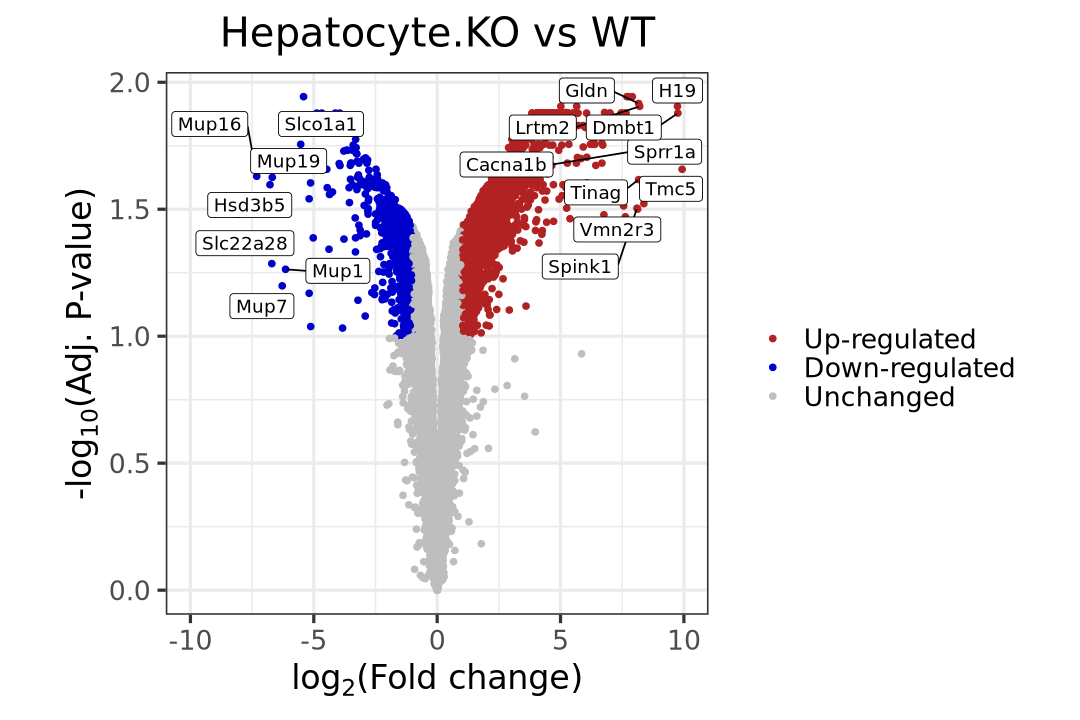

In [9]:
options(repr.plot.width = 9,repr.plot.height = 6)

g <- ddr.genes.nbinomwaldtest.genotype_KO_vs_WT.anno %>% 

(function(.) ggplot(.,mapping = aes(
    x = log2FoldChange,y = -log10(padj),
    col = case_when(
        log2FoldChange >= 1 & padj < .05 ~ 'Up-regulated',
        log2FoldChange <= -1 & padj < .05 ~ 'Down-regulated',
        .default = 'Unchanged'
    ) %>% factor(levels = c('Up-regulated','Down-regulated','Unchanged'))
)) +
geom_point() +
scale_color_manual(name = '',values = c('Up-regulated' = 'firebrick','Down-regulated' = 'mediumblue','Unchanged' = 'gray')) +

geom_label_repel(max.overlaps = 50,
    data = filter(.,log2FoldChange >= 1 & padj < .05) %>% arrange(-log2FoldChange) %>% head(n = 10),
    mapping = aes(label = symbol),col = 'black'
) +
geom_label_repel(max.overlaps = 50,
    data = filter(.,log2FoldChange <= -1 & padj < .05) %>% arrange(log2FoldChange) %>% head(n = 10),
    mapping = aes(label = symbol),col = 'black'
) +

labs(title = 'Hepatocyte.KO vs WT',x = expression('log'[2]*'(Fold change)'),y = expression('-log'[10]*'(Adj. P-value)')) +
coord_cartesian(xlim = c(-10,10)) +
theme_bw(base_size = 20) +
theme(plot.title = element_text(hjust = .5),aspect.ratio = 1)
)

g


In [10]:
ddr.genes.nbinomwaldtest.genotype_KO_vs_WT.gsego_bp <- ddr.genes.nbinomwaldtest.genotype_KO_vs_WT.anno %>% 
filter(padj < .05) %>% 
with(log2FoldChange %>% setNames(nm = ensembl_id)) %>% sort(decreasing = TRUE) %>% 
gseGO(ont = 'bp',OrgDb = org.Mm.eg.db,keyType = 'ENSEMBL',pvalueCutoff = .1)


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 17 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [11]:
ddr.genes.nbinomwaldtest.genotype_KO_vs_WT.gsego_bp %>% 
setReadable(OrgDb = org.Mm.eg.db) %>% 
data.frame %>% 
filter(grepl('interferon-beta',Description))


,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GO:0035458,GO:0035458,cellular response to interferon-beta,37,0.6582473,2.089593,9.413087e-07,2.933239e-05,2.209705e-05,950,"tags=86%, list=30%, signal=61%",Ifit1/Tgtp1/Oas1a/Ifi213/Ifi206/Ifi209/Gm5431/Trim6/Ifi211/Ifi208/Gbp3/Tgtp2/Gm12185/Ifi205/Oas1c/Igtp/Oas1b/Ifi204/Irgm1/Traf3ip3/Ifi47/9930111J21Rik1/Acod1/Mndal/Stat1/Ifi207/Gbp2b/Gbp2/Aim2/Irgm2/Gbp7/Ifi203
GO:0035456,GO:0035456,response to interferon-beta,43,0.6348983,2.063366,1.294375e-06,3.827653e-05,2.883496e-05,1000,"tags=84%, list=31%, signal=58%",Ifit1/Tgtp1/Oas1a/Ifi213/Ifi206/Ifi209/Gm5431/Xaf1/Trim6/Ifi211/Ifi208/Gbp3/Tgtp2/Gm12185/Ifi205/Oas1c/Igtp/Oas1b/Ifi204/Irgm1/Traf3ip3/Bst2/Ifi47/9930111J21Rik1/Acod1/Mndal/Stat1/Ifi207/Gbp2b/Gbp2/Aim2/Irgm2/Gbp7/Ifi203/Plscr1/Trex1
GO:0032608,GO:0032608,interferon-beta production,31,0.5547222,1.700744,3.849156e-03,2.867572e-02,2.160235e-02,1061,"tags=68%, list=33%, signal=46%",Oas3/Isg15/Oas1a/Oas2/Tlr9/Irf7/Oas1c/Traip/Oas1b/Tlr7/Traf3ip3/Pycard/Rigi/Ifih1/Ptpn22/Rnf135/Tlr3/Tlr8/Hmgb2/Tlr2/Nmi
GO:0032648,GO:0032648,regulation of interferon-beta production,31,0.5547222,1.700744,3.849156e-03,2.867572e-02,2.160235e-02,1061,"tags=68%, list=33%, signal=46%",Oas3/Isg15/Oas1a/Oas2/Tlr9/Irf7/Oas1c/Traip/Oas1b/Tlr7/Traf3ip3/Pycard/Rigi/Ifih1/Ptpn22/Rnf135/Tlr3/Tlr8/Hmgb2/Tlr2/Nmi
GO:0032728,GO:0032728,positive regulation of interferon-beta production,27,0.5567923,1.679948,4.247528e-03,3.039342e-02,2.289635e-02,1042,"tags=67%, list=33%, signal=45%",Oas3/Isg15/Oas1a/Oas2/Tlr9/Irf7/Oas1c/Oas1b/Tlr7/Traf3ip3/Rigi/Ifih1/Ptpn22/Rnf135/Tlr3/Tlr8/Hmgb2/Tlr2


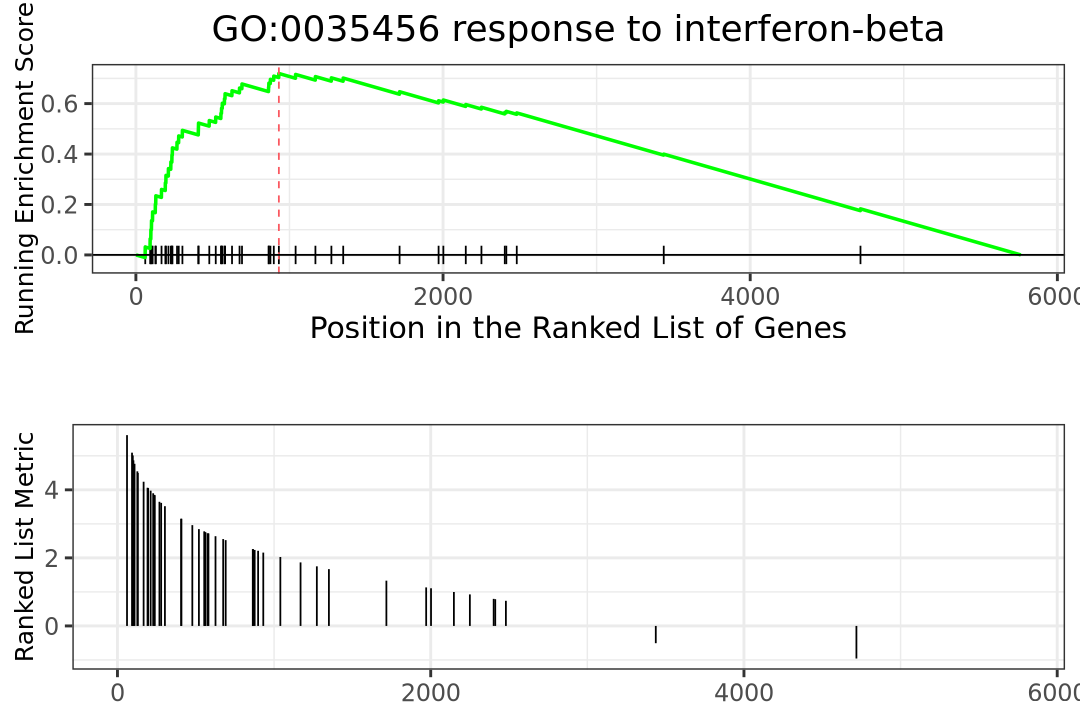

In [12]:
options(repr.plot.width = 9,repr.plot.height = 6)
library(gridExtra)

glist <- ddr.genes_cell.nbinomwaldtest.genotype_KO_vs_WT.anno.gsego_bp2 %>% 
gseaplot(geneSetID = 'GO:0035456')

g <- grid.arrange(
    glist[[2]] + labs(title = 'GO:0035456 response to interferon-beta') + theme_bw(base_size = 18) + theme(plot.title = element_text(hjust = .5),axis.title.y = element_text(size = 15)),
    glist[[1]] + theme_bw(base_size = 18) + theme(plot.title = element_text(hjust = .5),axis.title.y = element_text(size = 15)),
    ncol = 1
)


34



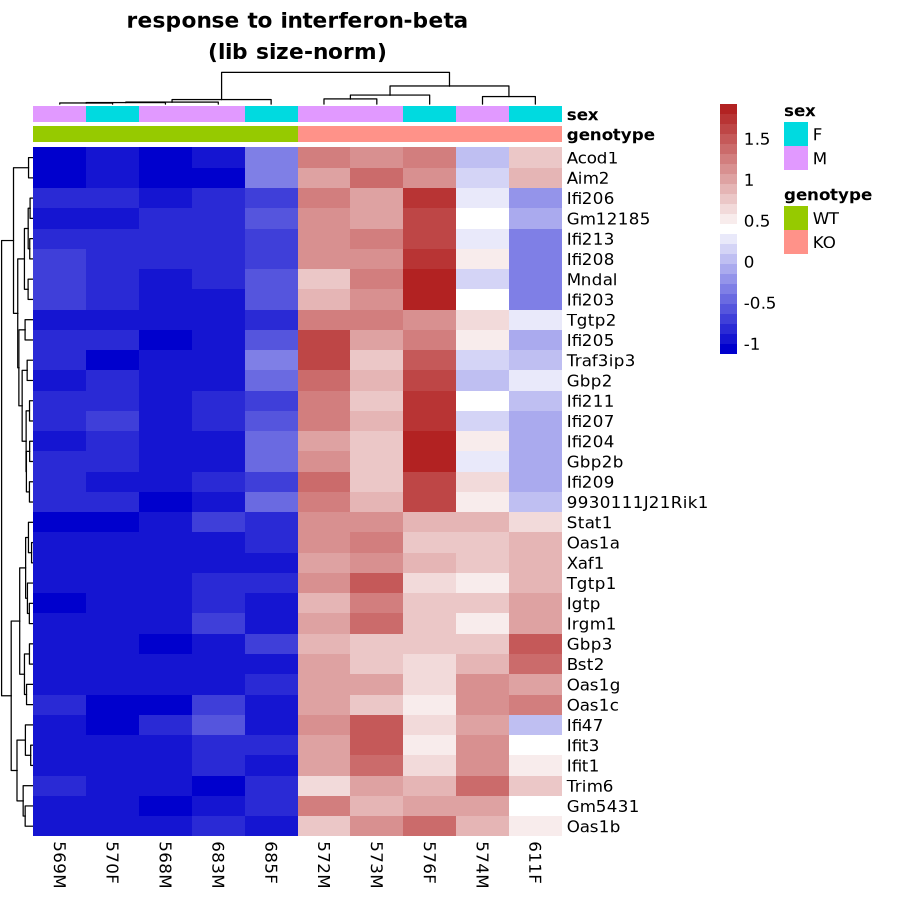

In [13]:
options(repr.plot.width = 7.5,repr.plot.height = 7.5)

(dds.genes_cell2 %>% counts(normalized = TRUE))[
    ddr.genes.nbinomwaldtest.genotype_KO_vs_WT.gsego_bp %>% 
    data.frame %>% 
    filter(ID == 'GO:0035456') %>% 
    with(core_enrichment) %>% 
    strsplit(split = '/') %>% 
    unlist
    ,
] %>% 
t %>% scale %>% t %>% 
(function(.) {
    nrow(.) %>% message
    
    myhclust.gene <- dist(.) %>% hclust %>% as.dendrogram %>% as.hclust
    myhclust.sample <- t(.) %>% dist %>% hclust %>% as.dendrogram %>% dendsort %>% as.hclust
    
    pheatmap(
        .,
        border_color = NA,
        main = 'response to interferon-beta\n(lib size-norm)',
        cluster_cols = myhclust.sample,
        cluster_rows = myhclust.gene,
        labels_row = (entrez_id.ensembl_id.symbol %>% column_to_rownames('ensembl_id'))[row.names(.),'symbol'],
        color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(25),
        treeheight_row = 15,treeheight_col = 15,
        annotation_col = coldata.cell
    )
})


11



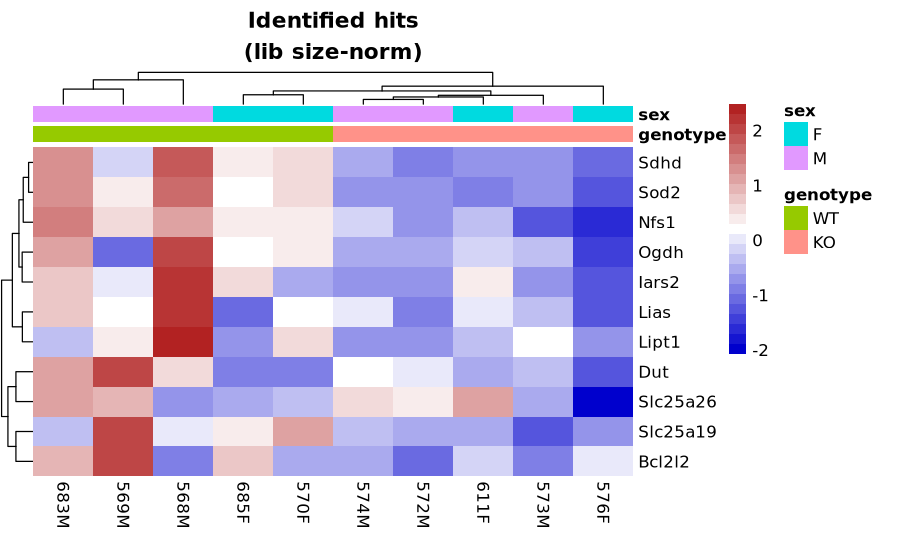

In [14]:
options(repr.plot.width = 7.5,repr.plot.height = 4.5)

g <- (dds.genes %>% counts(normalized = TRUE))[
    msigdbr.mm.go_bp %>% 
    distinct(human_gene_symbol,gene_symbol,entrez_gene,ensembl_gene) %>% 
    filter(human_gene_symbol %in% c(
    'SLC25A19',
    'LIAS',
    'SOD2',
    'SDHD',
    'LIPT1',
    'SLC25A26',
    'OGDH',
    'BCL2L2',
    'NFS1',
    'DUT',
    'IARS2'
    )) %>% with(ensembl_gene) %>% 
    intersect(dds.genes %>% row.names)
    ,
] %>% 
t %>% scale %>% t %>% 
(function(.) {
    nrow(.) %>% message
    
    myhclust.gene <- dist(.) %>% hclust %>% as.dendrogram %>% dendsort %>% as.hclust
    myhclust.sample <- t(.) %>% dist %>% hclust %>% as.dendrogram %>% rotate(order = 10:1) %>% as.hclust
    
    pheatmap(border_color = NA,
        .,
        main = 'Identified hits\n(lib size-norm)',
        cluster_cols = myhclust.sample,
        cluster_rows = myhclust.gene,
        labels_row = (entrez_id.ensembl_id.symbol %>% column_to_rownames('ensembl_id'))[row.names(.),'symbol'],
        color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(25),
        treeheight_row = 15,treeheight_col = 15,
        annotation_col = coldata.cell
    )
})

g


In [15]:
sessionInfo()


R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.4 (Ootpa)

Matrix products: default
BLAS/LAPACK: /home/users/nus/vincent2/micromamba/envs/R4.3-env/lib/libopenblasp-r0.3.26.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Singapore
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gridExtra_2.3               dendextend_1.18.0          
 [3] dendsort_0.3.4              ggrepel_0.9.6              
 [5] org.Mm.eg.db_3.18.0         AnnotationDbi_1.64.1  